In [1]:
!pip install ultralytics

print("✅ Installed necessary dependencies!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [3]:
import zipfile

dataset_path = "/content/archive (3).zip"  # Path to your uploaded dataset
extract_to = "/content/plant_disease"  # Destination folder

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Dataset extracted successfully!")


✅ Dataset extracted successfully!


In [5]:
!ls /content/plant_disease

plantvillage  PlantVillage  train  val


In [6]:
data_dir = "/content/plant_disease/plantvillage"  # or "/content/plant_disease/PlantVillage"

In [7]:
!ls /content/plant_disease/plantvillage
!ls /content/plant_disease/PlantVillage

PlantVillage
Pepper__bell___Bacterial_spot  Tomato_Bacterial_spot  Tomato_Septoria_leaf_spot
Pepper__bell___healthy	       Tomato_Early_blight    Tomato_Spider_mites_Two_spotted_spider_mite
Potato___Early_blight	       Tomato_healthy	      Tomato__Target_Spot
Potato___healthy	       Tomato_Late_blight     Tomato__Tomato_mosaic_virus
Potato___Late_blight	       Tomato_Leaf_Mold       Tomato__Tomato_YellowLeaf__Curl_Virus


In [8]:
data_dir = "/content/plant_disease/PlantVillage"

In [9]:
import os
import shutil

train_dir = "/content/plant_disease/train"
val_dir = "/content/plant_disease/val"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

if os.path.exists(data_dir):
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)

        if not os.path.isdir(class_path):
            continue  # Skip non-directory files

        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)

        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        filenames = os.listdir(class_path)
        split_index = int(0.8 * len(filenames))  # 80% for training

        train_filenames = filenames[:split_index]
        val_filenames = filenames[split_index:]

        # Copy files
        for filename in train_filenames:
            shutil.copy(os.path.join(class_path, filename), os.path.join(train_class_dir, filename))

        for filename in val_filenames:
            shutil.copy(os.path.join(class_path, filename), os.path.join(val_class_dir, filename))

    print("✅ Dataset split into training and validation sets.")
else:
    print("❌ Dataset directory not found. Check the extraction step.")


✅ Dataset split into training and validation sets.


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions
img_height, img_width = 256, 256

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

In [12]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
try:
    train_generator = train_datagen.flow_from_directory(
        "/content/plant_disease/train",
        target_size=(img_height, img_width),
        batch_size=64,
        class_mode='categorical',
        color_mode='rgb'
    )

    val_generator = val_datagen.flow_from_directory(
        "/content/plant_disease/val",
        target_size=(img_height, img_width),
        batch_size=64,
        class_mode='categorical',
        color_mode='rgb'
    )

    print("✅ Data augmentation and preprocessing completed successfully!")
except Exception as e:
    print(f"❌ Error during data preprocessing: {e}")


Found 16504 images belonging to 15 classes.
Found 4134 images belonging to 15 classes.
✅ Data augmentation and preprocessing completed successfully!


In [15]:
from ultralytics import YOLO

try:
    # Load pre-trained YOLO classification model
    model = YOLO("yolov8n-cls.pt")

    # Use the correct dataset path
    results = model.train(data="/content/plant_disease", epochs=50, imgsz=64)

    print("✅ Model training started successfully!")
except Exception as e:
    print(f"❌ Error during model training: {e}")

100%|██████████| 5.31M/5.31M [00:00<00:00, 109MB/s]

Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/plant_disease, epochs=50, time=None, patience=100, batch=16, imgsz=64, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: /content/plant_disease/train... found 16504 images in 15 classes ✅ 
val: /content/plant_disease/val... found 4134 images in 15 classes ✅ 
test: None...
Overriding model.yaml nc=1000 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
 

100%|██████████| 5.35M/5.35M [00:00<00:00, 108MB/s]


AMP: checks passed ✅


train: Scanning /content/plant_disease/train... 16504 images, 0 corrupt: 100%|██████████| 16504/16504 [00:02<00:00, 5586.12it/s]


train: New cache created: /content/plant_disease/train.cache


val: Scanning /content/plant_disease/val... 4134 images, 0 corrupt: 100%|██████████| 4134/4134 [00:00<00:00, 4823.78it/s]

val: New cache created: /content/plant_disease/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 64 train, 64 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/50     0.147G      2.933         16         64:   1%|          | 10/1032 [00:01<01:19, 12.91it/s]

       1/50     0.147G      2.936         16         64:   2%|▏         | 20/1032 [00:01<00:55, 18.33it/s]
100%|██████████| 755k/755k [00:00<00:00, 21.3MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:06<00:00, 20.68it/s]

                   all      0.798      0.982



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 25.74it/s]

                   all      0.811      0.991



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:06<00:00, 20.73it/s]

                   all      0.832      0.991



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 25.63it/s]

                   all      0.849      0.991



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 22.36it/s]

                   all       0.88      0.995



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 25.75it/s]

                   all      0.911      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:06<00:00, 21.24it/s]

                   all      0.894      0.998



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:04<00:00, 26.01it/s]


                   all       0.93      0.998

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:06<00:00, 21.04it/s]

                   all      0.912      0.999



      Epoch    GPU_mem       loss  Instances       Size


      10/50     0.138G     0.4169          8         64: 100%|██████████| 1032/1032 [00:52<00:00, 19.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 25.71it/s]

                   all      0.943      0.999



      Epoch    GPU_mem       loss  Instances       Size


      11/50     0.138G     0.3946          8         64: 100%|██████████| 1032/1032 [00:52<00:00, 19.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 22.79it/s]

                   all      0.937      0.998



      Epoch    GPU_mem       loss  Instances       Size


      12/50     0.138G     0.3917          8         64: 100%|██████████| 1032/1032 [00:53<00:00, 19.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 24.64it/s]


                   all       0.94      0.999

      Epoch    GPU_mem       loss  Instances       Size


      13/50     0.138G     0.3435          8         64: 100%|██████████| 1032/1032 [00:53<00:00, 19.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 24.45it/s]

                   all      0.955      0.999



      Epoch    GPU_mem       loss  Instances       Size


      14/50     0.138G     0.3318          8         64: 100%|██████████| 1032/1032 [00:51<00:00, 19.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 25.11it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


      15/50     0.138G     0.3392          8         64: 100%|██████████| 1032/1032 [00:54<00:00, 19.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:04<00:00, 26.03it/s]

                   all      0.964      0.999



      Epoch    GPU_mem       loss  Instances       Size


      16/50     0.138G     0.3077          8         64: 100%|██████████| 1032/1032 [00:53<00:00, 19.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:06<00:00, 20.33it/s]

                   all      0.956      0.999



      Epoch    GPU_mem       loss  Instances       Size


      17/50     0.138G     0.3038          8         64: 100%|██████████| 1032/1032 [00:54<00:00, 18.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 24.63it/s]

                   all      0.959      0.999



      Epoch    GPU_mem       loss  Instances       Size


      18/50     0.138G      0.296          8         64: 100%|██████████| 1032/1032 [00:52<00:00, 19.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 23.30it/s]

                   all      0.963      0.999



      Epoch    GPU_mem       loss  Instances       Size


      19/50     0.138G     0.2793          8         64: 100%|██████████| 1032/1032 [00:51<00:00, 19.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:04<00:00, 26.19it/s]

                   all      0.964      0.999



      Epoch    GPU_mem       loss  Instances       Size


      20/50     0.138G     0.2827          8         64: 100%|██████████| 1032/1032 [00:53<00:00, 19.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 22.92it/s]

                   all      0.964      0.999



      Epoch    GPU_mem       loss  Instances       Size


      21/50     0.138G     0.2732          8         64: 100%|██████████| 1032/1032 [00:51<00:00, 20.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:04<00:00, 26.11it/s]

                   all      0.967      0.999



      Epoch    GPU_mem       loss  Instances       Size


      22/50     0.138G     0.2617          8         64: 100%|██████████| 1032/1032 [00:51<00:00, 20.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:06<00:00, 20.91it/s]

                   all      0.963      0.999



      Epoch    GPU_mem       loss  Instances       Size


      23/50     0.138G     0.2484          8         64: 100%|██████████| 1032/1032 [00:52<00:00, 19.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 25.24it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


      24/50     0.138G     0.2516          8         64: 100%|██████████| 1032/1032 [00:52<00:00, 19.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:06<00:00, 21.33it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50     0.138G     0.2369          8         64: 100%|██████████| 1032/1032 [00:52<00:00, 19.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:04<00:00, 26.06it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50     0.138G     0.2298          8         64: 100%|██████████| 1032/1032 [00:54<00:00, 19.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 22.40it/s]

                   all      0.974          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50     0.138G     0.2322          8         64: 100%|██████████| 1032/1032 [00:53<00:00, 19.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:06<00:00, 20.89it/s]

                   all      0.976      0.999



      Epoch    GPU_mem       loss  Instances       Size


      28/50     0.138G     0.2089          8         64: 100%|██████████| 1032/1032 [00:54<00:00, 18.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 25.38it/s]

                   all      0.978      0.999



      Epoch    GPU_mem       loss  Instances       Size


      29/50     0.138G     0.2123          8         64: 100%|██████████| 1032/1032 [00:52<00:00, 19.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:06<00:00, 20.84it/s]

                   all      0.979      0.999



      Epoch    GPU_mem       loss  Instances       Size


      30/50     0.138G     0.2131          8         64: 100%|██████████| 1032/1032 [00:54<00:00, 19.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 25.37it/s]

                   all       0.98      0.999



      Epoch    GPU_mem       loss  Instances       Size


      31/50     0.138G     0.2043          8         64: 100%|██████████| 1032/1032 [00:53<00:00, 19.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 22.02it/s]


                   all      0.979      0.999

      Epoch    GPU_mem       loss  Instances       Size


      32/50     0.138G     0.2015          8         64: 100%|██████████| 1032/1032 [00:52<00:00, 19.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 25.71it/s]


                   all      0.982          1

      Epoch    GPU_mem       loss  Instances       Size


      33/50     0.138G      0.172          8         64: 100%|██████████| 1032/1032 [00:53<00:00, 19.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:06<00:00, 21.52it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


      34/50     0.138G     0.1792          8         64: 100%|██████████| 1032/1032 [00:52<00:00, 19.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 25.79it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50     0.138G     0.1775          8         64: 100%|██████████| 1032/1032 [00:53<00:00, 19.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 21.94it/s]

                   all      0.981          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50     0.138G      0.166          8         64: 100%|██████████| 1032/1032 [00:53<00:00, 19.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 22.99it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50     0.138G     0.1579          8         64: 100%|██████████| 1032/1032 [00:53<00:00, 19.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 25.14it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50     0.138G     0.1488          8         64: 100%|██████████| 1032/1032 [00:54<00:00, 19.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:06<00:00, 21.12it/s]

                   all      0.984      0.999



      Epoch    GPU_mem       loss  Instances       Size


      39/50     0.138G     0.1556          8         64: 100%|██████████| 1032/1032 [00:52<00:00, 19.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:04<00:00, 26.50it/s]

                   all      0.985      0.999



      Epoch    GPU_mem       loss  Instances       Size


      40/50     0.138G     0.1451          8         64: 100%|██████████| 1032/1032 [00:52<00:00, 19.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:07<00:00, 18.12it/s]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50     0.138G      0.138          8         64: 100%|██████████| 1032/1032 [00:52<00:00, 19.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 25.81it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50     0.138G     0.1322          8         64: 100%|██████████| 1032/1032 [00:52<00:00, 19.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:06<00:00, 21.51it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50     0.138G     0.1373          8         64: 100%|██████████| 1032/1032 [00:53<00:00, 19.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:04<00:00, 26.16it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50     0.138G     0.1294          8         64: 100%|██████████| 1032/1032 [00:52<00:00, 19.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:06<00:00, 21.21it/s]


                   all      0.987          1

      Epoch    GPU_mem       loss  Instances       Size


      45/50     0.138G       0.12          8         64: 100%|██████████| 1032/1032 [00:52<00:00, 19.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:04<00:00, 26.19it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


      46/50     0.138G     0.1148          8         64: 100%|██████████| 1032/1032 [00:53<00:00, 19.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:06<00:00, 20.68it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


      47/50     0.138G     0.1102          8         64: 100%|██████████| 1032/1032 [00:52<00:00, 19.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 25.24it/s]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


      48/50     0.138G     0.1095          8         64: 100%|██████████| 1032/1032 [00:54<00:00, 19.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:06<00:00, 20.95it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50     0.138G     0.1012          8         64: 100%|██████████| 1032/1032 [00:52<00:00, 19.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:05<00:00, 25.61it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


      50/50     0.138G     0.0988          8         64: 100%|██████████| 1032/1032 [00:52<00:00, 19.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:06<00:00, 20.81it/s]

                   all      0.987          1



50 epochs completed in 0.822 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.0MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,454,095 parameters, 0 gradients, 3.3 GFLOPs
train: /content/plant_disease/train... found 16504 images in 15 classes ✅ 
val: /content/plant_disease/val... found 4134 images in 15 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 130/130 [00:04<00:00, 26.65it/s]


                   all      0.987          1
Speed: 0.0ms preprocess, 0.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train
✅ Model training started successfully!


In [17]:
import numpy as np
from ultralytics import YOLO

try:
    # Load the best trained model
    model = YOLO("/content/runs/classify/train/weights/best.pt")

    # Path to a test image (update this based on your dataset)
    test_image = "/content/plant_disease/val/Tomato__Tomato_mosaic_virus/0befa341-0db3-49f4-b4fc-beeb05854bff___PSU_CG 2338.JPG"

    # Run the model on the test image
    results = model(test_image)

    # Extract predictions
    names_dict = results[0].names
    probs = results[0].probs.data.tolist()

    # Print predictions
    predictions = [(names_dict[i], prob) for i, prob in enumerate(probs)]
    print("🔍 Predictions:", predictions)
    print("✅ Prediction successful!")

except Exception as e:
    print(f"❌ Error during prediction: {e}")


image 1/1 /content/plant_disease/val/Tomato__Tomato_mosaic_virus/0befa341-0db3-49f4-b4fc-beeb05854bff___PSU_CG 2338.JPG: 64x64 Tomato__Tomato_mosaic_virus 1.00, Tomato_Spider_mites_Two_spotted_spider_mite 0.00, Tomato__Target_Spot 0.00, Tomato_Leaf_Mold 0.00, Tomato_Septoria_leaf_spot 0.00, 3.1ms
Speed: 14.4ms preprocess, 3.1ms inference, 0.1ms postprocess per image at shape (1, 3, 64, 64)
🔍 Predictions: [('Pepper__bell___Bacterial_spot', 5.438388073208955e-10), ('Pepper__bell___healthy', 4.497983374651682e-10), ('Potato___Early_blight', 1.971901530950504e-10), ('Potato___Late_blight', 4.360120708923887e-09), ('Potato___healthy', 1.321869391723851e-09), ('Tomato_Bacterial_spot', 2.49990339540318e-09), ('Tomato_Early_blight', 1.4218262833765039e-07), ('Tomato_Late_blight', 4.546347742717671e-09), ('Tomato_Leaf_Mold', 4.5864427988817624e-07), ('Tomato_Septoria_leaf_spot', 2.801650111905474e-07), ('Tomato_Spider_mites_Two_spotted_spider_mite', 9.661814146966208e-06), ('Tomato__Target_Spo

In [18]:
# Evaluate model performance on the validation dataset
metrics = model.val()

# Print evaluation results
print("📊 Evaluation Metrics:", metrics)

Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
train: /content/plant_disease/train... found 16504 images in 15 classes ✅ 
val: /content/plant_disease/val... found 4134 images in 15 classes ✅ 
test: None...


val: Scanning /content/plant_disease/val... 4134 images, 0 corrupt: 100%|██████████| 4134/4134 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 259/259 [00:05<00:00, 47.76it/s]


                   all      0.987          1
Speed: 0.0ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val
📊 Evaluation Metrics: ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7acfa12def10>
curves: []
curves_results: []
fitness: 0.9934687912464142
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9874213933944702, 'metrics/accuracy_top5': 0.9995161890983582, 'fitness': 0.9934687912464142}
save_dir: PosixPath('runs/classify/val')
speed: {'preprocess': 0.014482138364739881, 'inference': 0.3947677489131965, 'loss': 0.0011914368631632003, 'postprocess': 0.0017025645861454277}
task: 'classify'
top1: 0.9874213933944702
top5: 0.9995161890983582


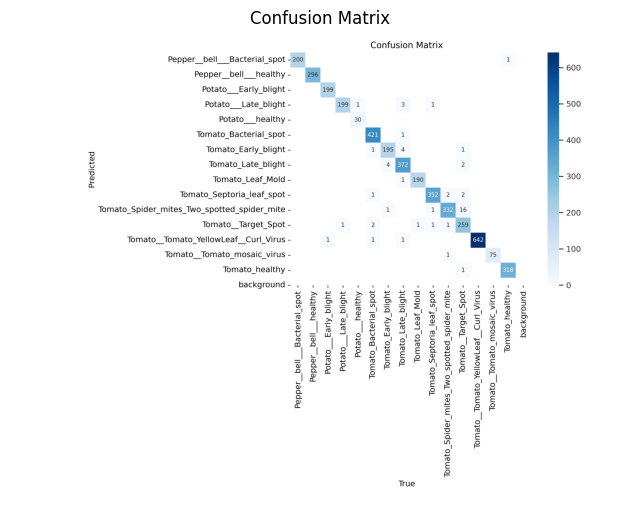

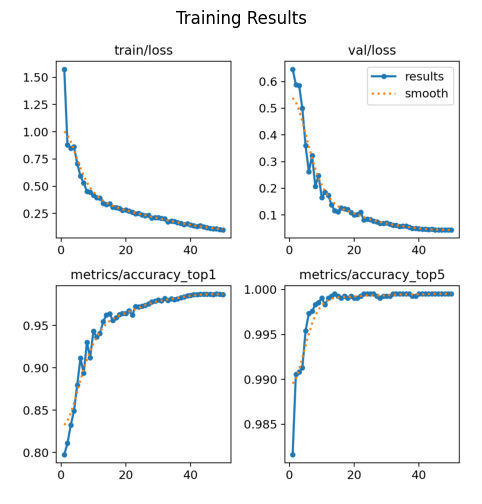

In [20]:
import matplotlib.pyplot as plt
import cv2

# Load and display the confusion matrix
conf_matrix_path = "/content/runs/classify/train/confusion_matrix.png"
conf_matrix = cv2.imread(conf_matrix_path)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(conf_matrix, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Confusion Matrix")
plt.show()

# Load and display training results (accuracy/loss curves)
results_path = "/content/runs/classify/train/results.png"
results_img = cv2.imread(results_path)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(results_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Training Results")
plt.show()

In [24]:
import numpy as np

# Load the trained model
model = YOLO("/content/runs/classify/train/weights/last.pt")

# Path to test image
test_image = "/content/plant_disease/val/Potato___Late_blight/02282fee-ba3f-460e-91e0-630204ab96c2___RS_LB 5031.JPG"  # Change accordingly

# Predict
results = model(test_image)

# Get class names and probabilities
names_dict = results[0].names
probs = results[0].probs.data.tolist()

# Print class names and probabilities
print(names_dict)
print(probs)
print("Predicted Class:", names_dict[np.argmax(probs)])



image 1/1 /content/plant_disease/val/Potato___Late_blight/02282fee-ba3f-460e-91e0-630204ab96c2___RS_LB 5031.JPG: 64x64 Potato___Late_blight 1.00, Potato___Early_blight 0.00, Pepper__bell___healthy 0.00, Tomato_Late_blight 0.00, Tomato_Septoria_leaf_spot 0.00, 4.3ms
Speed: 2.4ms preprocess, 4.3ms inference, 0.1ms postprocess per image at shape (1, 3, 64, 64)
{0: 'Pepper__bell___Bacterial_spot', 1: 'Pepper__bell___healthy', 2: 'Potato___Early_blight', 3: 'Potato___Late_blight', 4: 'Potato___healthy', 5: 'Tomato_Bacterial_spot', 6: 'Tomato_Early_blight', 7: 'Tomato_Late_blight', 8: 'Tomato_Leaf_Mold', 9: 'Tomato_Septoria_leaf_spot', 10: 'Tomato_Spider_mites_Two_spotted_spider_mite', 11: 'Tomato__Target_Spot', 12: 'Tomato__Tomato_YellowLeaf__Curl_Virus', 13: 'Tomato__Tomato_mosaic_virus', 14: 'Tomato_healthy'}
[3.668331061135177e-08, 3.0692201562487753e-06, 2.0490360839175992e-05, 0.9999704360961914, 1.0909921002166811e-06, 4.978212331252507e-08, 2.0942581002714178e-08, 2.6935288133245194

In [2]:
from ultralytics import YOLO

# Load the best-trained model
model = YOLO("/content/runs/classify/train/weights/best.pt")  # Update the correct path if different

# Save the model
model_path = "/content/GreenGuard_YOLOv8.pt"
model.save(model_path)

print(f"✅ Model saved successfully at {model_path}")

✅ Model saved successfully at /content/GreenGuard_YOLOv8.pt
